<a href="https://colab.research.google.com/github/unique-subedi/fruit-ripening-experiment/blob/main/Unique_fruit_ripening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime
import time
import math
import numpy as np
import scipy
from numpy import linalg as LA
import pandas as pd
import urllib.request
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
from scipy.stats import f_oneway

import random

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/fruit-ripening-experiment/main/data.csv", "data.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/fruit-ripening-experiment/main/banana.csv", "banana.csv")
data = pd.read_csv("data.csv")
banana = pd.read_csv("banana.csv")


In [4]:
df = pd.concat([data, banana.iloc[:,1:]], axis =1)
df.head()

,number,treatment,softness(wed),softness(mon),10-19_r,10-19_g,10-19_b,10-19_magnitude,10-20_r,10-20_g,...,10-22_b,10-22_magnitude,10-23_r,10-23_g,10-23_b,10-23_magnitude,10-24_r,10-24_g,10-24_b,10-24_magnitude
0,1,0,3.0,1.0,142.186631,142.200241,16.844182,201.796117,122.780859,96.179760,...,12.934295,146.366787,116.360128,83.802661,13.796252,144.058675,116.353494,81.629849,11.759836,142.617886
1,2,0,4.0,2.0,137.561795,136.596559,14.987055,194.438883,109.779719,88.955601,...,13.929320,152.601480,120.899058,87.045964,15.229069,149.751483,121.849632,87.021542,14.592494,150.442755
2,3,3,4.0,1.0,141.125241,146.216694,36.481745,206.462037,120.239765,98.022351,...,12.309653,148.847134,126.255641,92.621441,14.366583,157.243814,120.488485,85.541201,10.755849,148.156878
3,4,3,4.0,2.0,125.344966,143.395653,14.991416,191.045587,118.246539,100.222260,...,11.942055,150.629455,121.643766,89.222010,13.653187,151.473372,122.224136,87.660435,10.155163,150.752177
4,5,1,4.0,2.0,116.170423,138.321851,9.094297,180.862401,97.527673,85.330382,...,9.301796,141.101667,111.989788,81.149525,10.709202,138.714257,107.568616,75.318988,8.412993,131.585469


In [6]:
df_fl = df[['number', 'treatment', '10-19_g', '10-19_magnitude', '10-24_g', '10-24_magnitude']]
df_fl.head()
df_fl.loc[:, "green_diff"] =   df_fl["10-19_g"] - df_fl["10-24_g"]
df_fl.loc[:, "magnitude_diff"] =  df_fl["10-19_magnitude"] - df_fl["10-24_magnitude"]
df_fl.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,number,treatment,10-19_g,10-19_magnitude,10-24_g,10-24_magnitude,green_diff,magnitude_diff
0,1,0,142.200241,201.796117,81.629849,142.617886,60.570392,59.178231
1,2,0,136.596559,194.438883,87.021542,150.442755,49.575017,43.996128
2,3,3,146.216694,206.462037,85.541201,148.156878,60.675493,58.305159
3,4,3,143.395653,191.045587,87.660435,150.752177,55.735218,40.293410
4,5,1,138.321851,180.862401,75.318988,131.585469,63.002863,49.276932


In [7]:
def permutation_test(data_set, trt1, trt2,  variable):
   data_slice = data_set[data_set.treatment.isin([trt1, trt2])]
   diff_given = data_slice[data_slice.treatment == trt1][variable].mean() - data_slice[data_slice.treatment == trt2][variable].mean()
   differences = []
   treatments = data_slice["treatment"]
   for perms in itertools.permutations(treatments):
     data_slice.loc[:, "treatment"] = perms
     differences.append(data_slice[data_slice.treatment == trt1][variable].mean() - data_slice[data_slice.treatment == trt2][variable].mean())
   return differences, np.mean(differences >= diff_given)
    
    

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


0.9


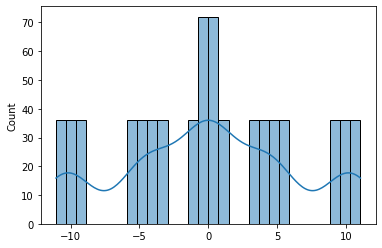

In [8]:
differences, p_value = permutation_test(df_fl, 2, 3, "green_diff")
print(p_value)
sns.histplot(differences, bins = 30, kde= True)

In [ ]:
var = "green_diff"
trt_zero = df_fl[df.treatment == 0][var]
trt_one = df_fl[df.treatment == 1][var]
trt_two = df_fl[df.treatment == 2][var]
trt_three = df_fl[df.treatment == 3][var]
F, p = f_oneway(trt_zero, trt_one, trt_two, trt_three)
print("statistic: ", F)
print("p-value: ", p)

statistic:  4.841743371100792
p-value:  0.033102305266664564


In [ ]:
def F_statistic(y):
  num = 3*y.groupby(level=0).mean().var()
  denom = y.groupby(level=0).var().sum()/4
  return num/denom



In [ ]:
def F_test(y):
    F = F_statistic(y)
    #permutations = random.choices(list(itertools.permutations(y.index)), k = 1000)
    hist = []
    initial = y.index
    i = 0
    for i in range(10000):
      y.index = np.random.permutation(initial)
      hist.append(F_statistic(y))
      F_temp = F_statistic(y)
      i+=1
    return np.mean(hist >= F), hist

In [ ]:
df_fl.index = df_fl["treatment"]
p_value, hist = F_test(df_fl["green_diff"])

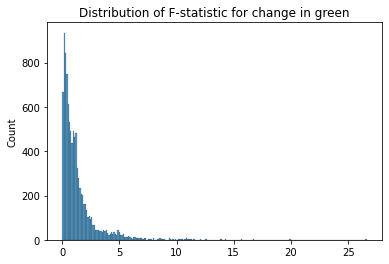

In [ ]:
sns.histplot(hist)
plt.title("Distribution of F-statistic for change in green")
plt.savefig("green.png")

In [ ]:
p_value

0.0453

In [ ]:
var = "magnitude_diff"
control = df_fl[df_fl.iloc[:,1] == 0]
group1 = df_fl[df_fl.iloc[:,1] == 1]
group2 = df_fl[df_fl.iloc[:,1] == 2]
group3 = df_fl[df_fl.iloc[:,1] == 3]
p_value, test_statistic = F_test(control, group1, group2, group3, var)

# Analysis on Color of Peel

On top of softness, we also studied ripeness with two variables based on color of peeel. 

## Change in color between the first and the last day of the experiment

Let us define $M_{ij}$ to be the magnitude of pixel for $i^{th}$ banana on $j^{th}$ day of the experiment. Since we ran experiment for 5 days, we have $j \in \{1, 2, 3,4, 5\}$. In this section, we study the variable 
$$\Delta M_i :=  M_{i1} - M_{i5},$$
that is, the change in pixel magnitude between the first and the last day of the experiment for each banana. In the similar manner, let us denote $G_{ij}$ to be average green chanel value for $i^{th}$ banana on $j^{th}$ day of the experiment. Then, we can define
$$\Delta G_i := G_{i1} - G_{i5}.$$



First, we begin by studying if there exist any pair of groups, either treatment-control pair or treatment-treatment pair, for which $\Delta M_i$ or $\Delta G_i$ is statistically different across these two groups in the pair. For this, we use permutation test using F-statistic as the test statistic. 
Since we have 12 observations across four groups, computing p-value requires computing test statistic for $12!$ permutations, which is infeasible. So, we compute our p-value using $10000$ randomly generated permutations. 

In [9]:
def F_statistic(y):
  num = 3*y.groupby(level=0).mean().var()
  denom = y.groupby(level=0).var().sum()/4
  return num/denom

def F_test(y):
    F = F_statistic(y)
    #permutations = random.choices(list(itertools.permutations(y.index)), k = 1000)
    hist = []
    initial = y.index
    i = 0
    for i in range(10000):
      y.index = np.random.permutation(initial)
      hist.append(F_statistic(y))
      F_temp = F_statistic(y)
      i+=1
    return np.mean(hist >= F), hist

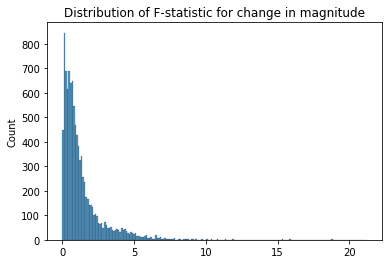

In [10]:
df_fl.index = df_fl["treatment"]
p_value, hist = F_test(df_fl["magnitude_diff"])
sns.histplot(hist)
plt.title("Distribution of F-statistic for change in magnitude")
plt.savefig("magnitude.png")